### Pathway Inclusion
An idea to model the problem including pathway information is to use a bipartite graph in which one set corresponds to the samples and another set corresponds to the genes. A node between those two sets exists if the expression level of that gene in the sample is bigger than a threshold $t_e$. The pathway information could be added by connecting gene nodes with each other that contribute to the same pathway based on data from string-db.org. The node is added if the score of this connection is bigger than a threshold $t_p$.

In [1]:
% load_ext autoreload
% autoreload 2
import sys
sys.path.append('..')
import os
import json
from src.data.load_data import get_small_dataset_content, get_big_dataset_content
from src.features.download import get_string_db_identifier, get_associated_genes, save_associated_genes
from src.features.normalize import select_variance_features, scale_df
from src.features.download import load_associated_genes
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from src.algorithms.bimax import BiMax

In [2]:
df, _ = get_big_dataset_content()

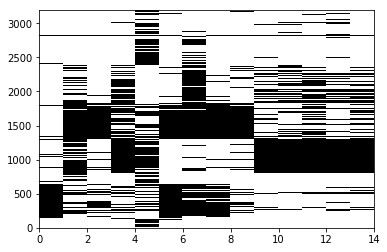

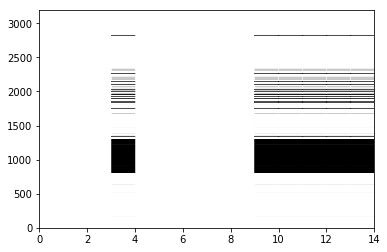

In [3]:
model = BiMax()
df_binary = df > 0
model.fit(df_binary.values)

# get largest bicluster
idx = np.argmax(list(model.rows_[i].sum() * model.columns_[i].sum() for i in range(len(model.rows_))))
bc = np.outer(model.rows_[idx], model.columns_[idx])

# plot data and overlay largest bicluster
plt.pcolor(df_binary.values, cmap=plt.cm.Greys)
plt.show()
plt.pcolor(bc, cmap=plt.cm.Greys, alpha=0.7)
plt.show()

In [4]:
from collections import defaultdict


def find_cliques(graph):
    p = set(graph.keys())
    r = set()
    x = set()
    cliques = []
    for v in degeneracy_ordering(graph):
        neighs = graph[v]
        find_cliques_pivot(graph, r.union([v]), p.intersection(neighs), x.intersection(neighs), cliques)
        p.remove(v)
        x.add(v)
    return sorted(cliques, lambda x: len(x))


def find_cliques_pivot(graph, r, p, x, cliques):
    if len(p) == 0 and len(x) == 0:
        cliques.append(r)
    else:
        u = iter(p.union(x)).next()
        for v in p.difference(graph[u]):
            neighs = graph[v]
            find_cliques_pivot(graph, r.union([v]), p.intersection(neighs), x.intersection(neighs), cliques)
            p.remove(v)
            x.add(v)


def degeneracy_ordering(graph):
    ordering = []
    ordering_set = set()
    degrees = defaultdict(lambda: 0)
    degen = defaultdict(list)
    max_deg = -1
    for v in graph:
        deg = len(graph[v])
        degen[deg].append(v)
        degrees[v] = deg
        if deg > max_deg:
            max_deg = deg

    while True:
        i = 0
        while i <= max_deg:
            if len(degen[i]) != 0:
                break
            i += 1
        else:
            break
        v = degen[i].pop()
        ordering.append(v)
        ordering_set.add(v)
        for w in graph[v]:
            if w not in ordering_set:
                deg = degrees[w]
                degen[deg].remove(w)
                if deg > 0:
                    degrees[w] -= 1
                    degen[deg - 1].append(w)

    ordering.reverse()
    return ordering

In [5]:
NEIGHBORS = [
    [], # I want to start index from 1 instead of 0
    [2, 3, 4],
    [1, 3, 4, 5],
    [1, 2, 4, 5],
    [1, 2, 3],
    [2, 3, 6, 7],
    [5, 7],
    [5, 6],
]
NODES = set(range(1, len(NEIGHBORS)))

MIN_SIZE = 3

cliques = []
def bronker_bosch2(all_cliques, clique, candidates, excluded):
    '''Bron–Kerbosch algorithm with pivot'''
    if not candidates and not excluded:
        if len(clique) >= MIN_SIZE:
            all_cliques.append(clique)
        return all_cliques
 
    pivot = pick_random(candidates) or pick_random(excluded)
    for v in list(candidates.difference(NEIGHBORS[pivot])):
        new_candidates = candidates.intersection(NEIGHBORS[v])
        new_excluded = excluded.intersection(NEIGHBORS[v])
        bronker_bosch2(all_cliques, clique + [v], new_candidates, new_excluded)
        candidates.remove(v)
        excluded.add(v)
    return all_cliques


def pick_random(s):
    if s:
        elem = s.pop()
        s.add(elem)
        return elem
    
bronker_bosch2([], [], set(NODES), set())

[[1, 2, 3, 4], [5, 2, 3], [5, 6, 7]]

In [6]:
# Without gene inter-connection
MIN_SIZE = 2
NEIGHBORS = [
    [], # I want to start index from 1 instead of 0
    [4],
    [4, 5],
    [5],
    [],
    []
]
NODES = set(range(1, len(NEIGHBORS)))
bronker_bosch2([], [], set(NODES), set())

[[1, 4], [2, 4], [2, 5], [3, 5]]

In [7]:
# With edge between gene vertices
MIN_SIZE = 3
NEIGHBORS = [
    [], # I want to start index from 1 instead of 0
    [4],
    [4, 5],
    [5],
    [5],
    [4]
]
NODES = set(range(1, len(NEIGHBORS)))
bronker_bosch2([], [], set(NODES), set())

[[2, 4, 5]]

In [8]:
df.head()

,ENSG00000042832,ENSG00000086548,ENSG00000122852,ENSG00000128422,ENSG00000129824,ENSG00000136352,ENSG00000157765,ENSG00000168878,ENSG00000185303,ENSG00000185479,ENSG00000186081,ENSG00000186832,ENSG00000186847,ENSG00000205420
sample_id,,,,,,,,,,,,,,
0,-0.390651,-0.874771,-0.651031,-1.326890,1.105814,-0.671635,-1.117481,-0.721843,-0.475640,-0.571603,-0.078680,-0.932995,-0.821309,-0.701825
1,-0.546451,-1.045201,-0.651031,-0.846695,1.272846,-0.826816,-0.570226,-0.758942,-0.726717,-0.678175,-1.041723,-0.365608,-0.821309,-0.884311
2,-0.294704,-0.334087,-0.651031,-0.901615,1.147219,0.153893,-0.745637,-0.686860,-0.619298,-0.537545,-0.612176,-0.795993,-0.821309,-0.762039
3,-0.368586,-1.044671,-0.651031,-0.009298,-0.160563,-0.664179,-0.352765,-0.758210,-0.557765,-0.678175,0.419710,-0.104387,-0.648623,-0.032136
4,-0.387323,-1.161929,-0.651031,-1.273913,-0.192725,-0.826816,-1.023866,-0.765135,-0.156699,-0.678175,-0.226191,-0.932995,-0.821309,-0.770710


A sample node $n_s$ has a gene neighbor $n_g$ if the expression of that gene in the sample is bigger than $\tau_e$.

In [9]:
NEIGHBORS = [[]] # I want to start index from 1 instead of 0
TAU_E = 0
gene_neighbor_id_map = {}
# Build from first set of vertices (samples)
for row_index, row in df.iterrows():
    sample_neighbors = []
    for column, item in row.iteritems():
        if item > TAU_E:
            if column not in gene_neighbor_id_map.keys():
                gene_neighbor_id_map[column] = len(df) + 1 + list(row.index).index(column)
            sample_neighbors.append(gene_neighbor_id_map[column])
    NEIGHBORS.append(sample_neighbors)

# Build from second set of vertices (samples)
for _ in df.columns:
    NEIGHBORS.append([])

In [10]:
MIN_SIZE = 2
NODES = set(range(1, len(NEIGHBORS)))
bronker_bosch2([], [], set(NODES), set())[:10]

[[1, 3194],
 [2, 3194],
 [3, 3194],
 [3, 3195],
 [4, 3200],
 [6, 3194],
 [6, 3195],
 [7, 3194],
 [9, 3194],
 [13, 3194]]

In [11]:
assert len(NEIGHBORS) == len(df) + len(df.columns) + 1
gene_neighbors = NEIGHBORS[-len(df.columns):]
assert len(gene_neighbors) == len(df.columns)
for x in gene_neighbors:
    assert len(x) == 0

We now need to interconnect the vertices of the gene set. Two gene nodes $n_{g1}$ and $n_{g2}$ are connected if their estimated interconnectivity given by the db_score of the StringDB database is higher than $\tau_i$.

In [12]:
df_associations = pd.DataFrame(index=df.columns, columns=df.columns)
df_associations = df_associations.fillna(0)
# Show from identifier in column to identifier used by StringDB
identifier_map = {}
for identifier in df.columns:
    path = os.path.join('../data/external', "{}.json".format(identifier))
    string_db_id = json.load(open(path))["identifier"]
    identifier_map[identifier] = string_db_id
    
TAU_I = 0.5
for gene in df.columns:
    associated_genes = load_associated_genes(identifier=gene)
    for associated_gene in associated_genes:
        if associated_gene["dscore"] > TAU_I:
            associated_gene_name = associated_gene["stringId"]
            if associated_gene_name in identifier_map.keys() or associated_gene_name in identifier_map.values():
                # Associated gene name to column gene name
                for column_gene_id, string_gene_id in identifier_map.items():
                    if associated_gene_name == string_gene_id:
                        associated_gene_name = column_gene_id
                        break
                # Search the associated gene name in the identifiers map
                for column_gene_id, string_gene_id in identifier_map.items():
                    if column_gene_id == associated_gene_name:
                        df_associations.loc[gene, associated_gene_name] = 1
                        break
assert df_associations.loc["ENSG00000168878", "ENSG00000185303"] == 1
assert df_associations.loc["ENSG00000185303", "ENSG00000168878"] == 1
# Matrix should be symmtric
assert np.allclose(df_associations, df_associations.T, atol=1e-8)
df_associations

,ENSG00000042832,ENSG00000086548,ENSG00000122852,ENSG00000128422,ENSG00000129824,ENSG00000136352,ENSG00000157765,ENSG00000168878,ENSG00000185303,ENSG00000185479,ENSG00000186081,ENSG00000186832,ENSG00000186847,ENSG00000205420
ENSG00000042832,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000086548,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000122852,0,0,0,0,0,0,0,1,1,0,0,0,0,0
ENSG00000128422,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000129824,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000136352,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000157765,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000168878,0,0,1,0,0,0,0,0,1,0,0,0,0,0
ENSG00000185303,0,0,1,0,0,0,0,1,0,0,0,0,0,0
ENSG00000185479,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
NEIGHBORS = [[]] # I want to start index from 1 instead of 0
TAU_E = 0
TAU_I = 0
gene_neighbor_id_map = {}
# Build from first set of vertices (samples)
for row_index, row in df.iterrows():
    sample_neighbors = []
    for column, item in row.iteritems():
        if item > TAU_E:
            if column not in gene_neighbor_id_map.keys():
                gene_neighbor_id_map[column] = len(df) + 1 + list(row.index).index(column)
            sample_neighbors.append(gene_neighbor_id_map[column])
    NEIGHBORS.append(sample_neighbors)

# Build from second set of vertices (samples)
for col_index, gene in enumerate(df.columns):
    gene_neighbors = []
    for associated_gene in df_associations.columns:
        if df_associations.loc[gene, associated_gene] == 1:
            gene_neighbors.append(gene_neighbor_id_map[associated_gene])
    NEIGHBORS.append(gene_neighbors)

In [14]:
assert len(NEIGHBORS) == len(df) + len(df.columns) + 1
gene_neighbors = NEIGHBORS[-len(df.columns):]
assert len(gene_neighbors) == len(df.columns)

In [15]:
MIN_SIZE = 3
NODES = set(range(1, len(NEIGHBORS)))
bronker_bosch2([], [], set(NODES), set())[:20]

[[120, 3192, 3198],
 [156, 3192, 3197],
 [161, 3192, 3197, 3198],
 [162, 3192, 3197],
 [163, 3192, 3197, 3198],
 [164, 3192, 3197],
 [171, 3192, 3197, 3198],
 [174, 3192, 3197],
 [176, 3192, 3197],
 [177, 3192, 3197, 3198],
 [178, 3192, 3197, 3198],
 [179, 3192, 3197],
 [184, 3192, 3197],
 [185, 3192, 3197, 3198],
 [191, 3192, 3197, 3198],
 [193, 3192, 3197],
 [194, 3192, 3197],
 [196, 3192, 3198],
 [198, 3192, 3197],
 [199, 3192, 3197]]

In [16]:
df.append(df_associations).iloc[[3192-1, 3197-1, 3198-1], :] 

,ENSG00000042832,ENSG00000086548,ENSG00000122852,ENSG00000128422,ENSG00000129824,ENSG00000136352,ENSG00000157765,ENSG00000168878,ENSG00000185303,ENSG00000185479,ENSG00000186081,ENSG00000186832,ENSG00000186847,ENSG00000205420
ENSG00000122852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
ENSG00000168878,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
ENSG00000185303,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
df.append(df_associations).tail(20)

,ENSG00000042832,ENSG00000086548,ENSG00000122852,ENSG00000128422,ENSG00000129824,ENSG00000136352,ENSG00000157765,ENSG00000168878,ENSG00000185303,ENSG00000185479,ENSG00000186081,ENSG00000186832,ENSG00000186847,ENSG00000205420
3183,-0.288326,-0.976277,-0.313484,0.112241,-0.406345,-0.826816,-1.327374,-0.547949,-0.173233,-0.501246,-0.223690,-0.621095,-0.084677,-0.210220
3184,0.135420,-1.161929,-0.651031,-1.423934,-0.797220,-0.826816,-1.594982,-0.751922,-0.726717,-0.204388,-0.952479,-0.834884,-0.821309,-0.884311
3185,-0.058217,-1.161929,-0.651031,-0.835044,-0.464511,-0.826816,-1.594982,-0.488896,-0.726717,-0.569827,-1.041723,-0.561898,0.107819,-0.884311
3186,-0.652419,0.181519,-0.510030,1.055266,-1.050199,-0.267672,-1.464393,-0.528277,-0.726717,-0.450221,-0.762313,-0.750237,-0.700625,-0.884311
3187,0.396891,-1.161929,-0.651031,0.157615,-0.942955,0.249171,-1.454482,-0.712207,-0.726717,-0.575937,-0.863087,-0.644809,-0.729050,-0.884311
3188,-0.018946,-1.161929,-0.551398,-0.326286,1.253670,-0.729003,-1.594982,-0.841800,-0.726717,-0.678175,-1.041723,-0.575128,-0.701209,-0.768594
ENSG00000042832,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000086548,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000122852,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000128422,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [31]:
cliques = bronker_bosch2([], [], set(NODES), set())[:20]
print(cliques)

bicluster_dict = {}
for clique in cliques:
    sample_id = clique.pop(0)
    key = []
    for row_index in clique:
        key.append(df_associations.iloc[row_index-len(df)-1].name)
    key = ','.join(key)
    if key not in bicluster_dict.keys():
        bicluster_dict[key] = [sample_id]
    else:
        bicluster_dict[key].append(sample_id)
bicluster_dict

[[120, 3192, 3198], [156, 3192, 3197], [161, 3192, 3197, 3198], [162, 3192, 3197], [163, 3192, 3197, 3198], [164, 3192, 3197], [171, 3192, 3197, 3198], [174, 3192, 3197], [176, 3192, 3197], [177, 3192, 3197, 3198], [178, 3192, 3197, 3198], [179, 3192, 3197], [184, 3192, 3197], [185, 3192, 3197, 3198], [191, 3192, 3197, 3198], [193, 3192, 3197], [194, 3192, 3197], [196, 3192, 3198], [198, 3192, 3197], [199, 3192, 3197]]


{'ENSG00000122852,ENSG00000168878': [156,
  162,
  164,
  174,
  176,
  179,
  184,
  193,
  194,
  198,
  199],
 'ENSG00000122852,ENSG00000168878,ENSG00000185303': [161,
  163,
  171,
  177,
  178,
  185,
  191],
 'ENSG00000122852,ENSG00000185303': [120, 196]}